Tensor flow development

In [201]:
# mlp for binary classification
import pandas as pd
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
import tensorflow as tf
import re
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
import numpy as np

In [192]:
def addition(a, b):
    if (len(a) > 0):
        a = a[0]
    else:
        a = 0

    if (len(b) > 0):
        b = b[0]
    else:
        b = 0

    return a + b

def prepare_data(data, names, isTraining = True):
    # We have NaN values
    data["Age"] = data.Age.fillna(data.Age.mean())
    data["Cabin"] = data.Cabin.fillna("")

    # Let's calculate number of tickets
    data["numberCabins"] = [len(re.findall("[A-Z]", i)) for i in data["Cabin"]]
    data["classTicket"] = [re.findall("[A-Z]", i) for i in data["Cabin"]]
    classTickets = []
    for item in data["classTicket"]:
        if len(item) > 0:
            classTickets.append(item[0])
        else:
            classTickets.append("")

    data["classTicket"] = classTickets

    # Train and test input data
    data['Sex'] = pd.factorize(data.Sex)[0]
    data['Embarked'] = pd.factorize(data.Embarked)[0]
    data['classTicket'] = pd.factorize(data.classTicket)[0]

    # define the document
    listNames = []
    for item in data["Name"]:
        listNames.extend(item.split(" "))
    
    separator = " "
    listNames = separator.join(listNames)
    listNames = text_to_word_sequence(listNames)
    
    t = Tokenizer()
    t.fit_on_texts(listNames)
    
    names = []
    for name in data["Name"]:
        number = sum(t.texts_to_sequences(name), [])
        names.append(len(number))
            
    data["Name"] = names
    

    if (isTraining):
        X = data.drop(["PassengerId", "Ticket","Survived","Cabin"], axis=1)
        y = data["Survived"]
    else:
        X = data.drop(["PassengerId", "Ticket","Cabin"], axis=1)        
        y = []

    scaler = MinMaxScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)   
    
    return [X, y]

In [ ]:
# Download dataset
TITANIC_TRAIN = "/data/train.csv"
TITANIC_TEST = "/data/test.csv"

names = ["PassengerId", "Survived", "Pclass", "Name", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]
names_training = ["PassengerId", "Pclass", "Name", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]
data = pd.read_csv(TITANIC_TRAIN, names=names, skiprows=1)
test = pd.read_csv(TITANIC_TEST, names=names_training, skiprows=1)

[X, y] = prepare_data(data, names)
[X_test, _] = prepare_data(test, names_training, False)

In [197]:
print(X)
print(X_test)

     Pclass      Name  Sex       Age  SibSp     Parch      Fare  Embarked  \
0       1.0  0.173913  0.0  0.271174  0.125  0.000000  0.014151  0.333333   
1       0.0  0.630435  1.0  0.472229  0.125  0.000000  0.139136  0.666667   
2       1.0  0.152174  1.0  0.321438  0.000  0.000000  0.015469  0.333333   
3       0.0  0.478261  1.0  0.434531  0.125  0.000000  0.103644  0.333333   
4       1.0  0.217391  0.0  0.434531  0.000  0.000000  0.015713  0.333333   
..      ...       ...  ...       ...    ...       ...       ...       ...   
886     0.5  0.108696  0.0  0.334004  0.000  0.000000  0.025374  0.333333   
887     0.0  0.304348  1.0  0.233476  0.000  0.000000  0.058556  0.333333   
888     1.0  0.434783  1.0  0.367921  0.125  0.333333  0.045771  0.333333   
889     0.0  0.173913  0.0  0.321438  0.000  0.000000  0.058556  0.666667   
890     1.0  0.086957  0.0  0.396833  0.000  0.000000  0.015127  1.000000   

     numberCabins  classTicket  
0            0.00        0.000  
1        

Epoch 1/1000
9/9 [==============================] - 0s 27ms/step - loss: 1.5121 - accuracy: 0.4457 - val_loss: 1.5034 - val_accuracy: 0.4258
Epoch 2/1000
9/9 [==============================] - 0s 9ms/step - loss: 1.4706 - accuracy: 0.4925 - val_loss: 1.4626 - val_accuracy: 0.4846
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 1.4331 - accuracy: 0.6049 - val_loss: 1.4234 - val_accuracy: 0.6387
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - loss: 1.3972 - accuracy: 0.7322 - val_loss: 1.3873 - val_accuracy: 0.7283
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 1.3629 - accuracy: 0.7921 - val_loss: 1.3538 - val_accuracy: 0.7647
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 1.3320 - accuracy: 0.7903 - val_loss: 1.3220 - val_accuracy: 0.7731
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 1.3029 - accuracy: 0.7790 - val_loss: 1.2924 - val_accuracy: 0.7731
Epoch 8/1000
9/9 [=

9/9 [==============================] - 0s 7ms/step - loss: 0.6576 - accuracy: 0.8015 - val_loss: 0.6639 - val_accuracy: 0.7759
Epoch 60/1000
9/9 [==============================] - 0s 8ms/step - loss: 0.6530 - accuracy: 0.8015 - val_loss: 0.6592 - val_accuracy: 0.7759
Epoch 61/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.6485 - accuracy: 0.8015 - val_loss: 0.6548 - val_accuracy: 0.7759
Epoch 62/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.6445 - accuracy: 0.8015 - val_loss: 0.6510 - val_accuracy: 0.7759
Epoch 63/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.6405 - accuracy: 0.8015 - val_loss: 0.6469 - val_accuracy: 0.7759
Epoch 64/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.6364 - accuracy: 0.8015 - val_loss: 0.6433 - val_accuracy: 0.7759
Epoch 65/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.6326 - accuracy: 0.8015 - val_loss: 0.6398 - val_accuracy: 0.7759
Epoch 66/1000
9/9 [========

Epoch 117/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.5302 - accuracy: 0.8015 - val_loss: 0.5390 - val_accuracy: 0.7759
Epoch 118/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.5294 - accuracy: 0.7996 - val_loss: 0.5387 - val_accuracy: 0.7759
Epoch 119/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.5289 - accuracy: 0.7996 - val_loss: 0.5383 - val_accuracy: 0.7731
Epoch 120/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.5277 - accuracy: 0.7996 - val_loss: 0.5370 - val_accuracy: 0.7759
Epoch 121/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.5268 - accuracy: 0.8015 - val_loss: 0.5363 - val_accuracy: 0.7759
Epoch 122/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.5261 - accuracy: 0.7996 - val_loss: 0.5354 - val_accuracy: 0.7759
Epoch 123/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.5252 - accuracy: 0.7996 - val_loss: 0.5346 - val_accuracy: 0.7759
Epoch 

Epoch 175/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.5024 - accuracy: 0.7996 - val_loss: 0.5106 - val_accuracy: 0.7787
Epoch 176/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.5026 - accuracy: 0.8034 - val_loss: 0.5107 - val_accuracy: 0.7759
Epoch 177/1000
9/9 [==============================] - 0s 8ms/step - loss: 0.5022 - accuracy: 0.8034 - val_loss: 0.5096 - val_accuracy: 0.7787
Epoch 178/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.5018 - accuracy: 0.8015 - val_loss: 0.5092 - val_accuracy: 0.7787
Epoch 179/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.5016 - accuracy: 0.7996 - val_loss: 0.5094 - val_accuracy: 0.7787
Epoch 180/1000
9/9 [==============================] - 0s 9ms/step - loss: 0.5015 - accuracy: 0.7996 - val_loss: 0.5093 - val_accuracy: 0.7787
Epoch 181/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.5015 - accuracy: 0.7996 - val_loss: 0.5092 - val_accuracy: 0.7787
Epoch 

9/9 [==============================] - 0s 10ms/step - loss: 0.4931 - accuracy: 0.8015 - val_loss: 0.5008 - val_accuracy: 0.7815
Epoch 233/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4936 - accuracy: 0.8034 - val_loss: 0.5004 - val_accuracy: 0.7787
Epoch 234/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4923 - accuracy: 0.8052 - val_loss: 0.5005 - val_accuracy: 0.7815
Epoch 235/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4933 - accuracy: 0.8015 - val_loss: 0.5011 - val_accuracy: 0.7815
Epoch 236/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4931 - accuracy: 0.8034 - val_loss: 0.5009 - val_accuracy: 0.7787
Epoch 237/1000
9/9 [==============================] - 0s 8ms/step - loss: 0.4926 - accuracy: 0.8034 - val_loss: 0.5003 - val_accuracy: 0.7787
Epoch 238/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4924 - accuracy: 0.8034 - val_loss: 0.5001 - val_accuracy: 0.7815
Epoch 239/1000
9/9 [

Epoch 290/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4868 - accuracy: 0.8071 - val_loss: 0.4944 - val_accuracy: 0.7815
Epoch 291/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4870 - accuracy: 0.8071 - val_loss: 0.4948 - val_accuracy: 0.7787
Epoch 292/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.4867 - accuracy: 0.8071 - val_loss: 0.4947 - val_accuracy: 0.7815
Epoch 293/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4870 - accuracy: 0.8090 - val_loss: 0.4948 - val_accuracy: 0.7787
Epoch 294/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4865 - accuracy: 0.8071 - val_loss: 0.4950 - val_accuracy: 0.7815
Epoch 295/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4864 - accuracy: 0.8034 - val_loss: 0.4949 - val_accuracy: 0.7815
Epoch 296/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4867 - accuracy: 0.8034 - val_loss: 0.4951 - val_accuracy: 0.7815
Epoch 

9/9 [==============================] - 0s 7ms/step - loss: 0.4827 - accuracy: 0.8090 - val_loss: 0.4926 - val_accuracy: 0.7787
Epoch 348/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4825 - accuracy: 0.8090 - val_loss: 0.4920 - val_accuracy: 0.7815
Epoch 349/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4826 - accuracy: 0.8052 - val_loss: 0.4924 - val_accuracy: 0.7815
Epoch 350/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4832 - accuracy: 0.8052 - val_loss: 0.4915 - val_accuracy: 0.7815
Epoch 351/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4826 - accuracy: 0.8090 - val_loss: 0.4915 - val_accuracy: 0.7815
Epoch 352/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4823 - accuracy: 0.8090 - val_loss: 0.4917 - val_accuracy: 0.7787
Epoch 353/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.4828 - accuracy: 0.8090 - val_loss: 0.4915 - val_accuracy: 0.7787
Epoch 354/1000
9/9 [

Epoch 405/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4791 - accuracy: 0.8071 - val_loss: 0.4891 - val_accuracy: 0.7815
Epoch 406/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4788 - accuracy: 0.8090 - val_loss: 0.4892 - val_accuracy: 0.7787
Epoch 407/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4790 - accuracy: 0.8090 - val_loss: 0.4891 - val_accuracy: 0.7787
Epoch 408/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4788 - accuracy: 0.8090 - val_loss: 0.4887 - val_accuracy: 0.7815
Epoch 409/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4790 - accuracy: 0.8090 - val_loss: 0.4888 - val_accuracy: 0.7815
Epoch 410/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4797 - accuracy: 0.8071 - val_loss: 0.4888 - val_accuracy: 0.7815
Epoch 411/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4793 - accuracy: 0.8090 - val_loss: 0.4886 - val_accuracy: 0.7787
Epoch 

Epoch 463/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4759 - accuracy: 0.8071 - val_loss: 0.4848 - val_accuracy: 0.7815
Epoch 464/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4760 - accuracy: 0.8034 - val_loss: 0.4848 - val_accuracy: 0.7815
Epoch 465/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4760 - accuracy: 0.8071 - val_loss: 0.4847 - val_accuracy: 0.7815
Epoch 466/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4758 - accuracy: 0.8071 - val_loss: 0.4850 - val_accuracy: 0.7815
Epoch 467/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4764 - accuracy: 0.8071 - val_loss: 0.4860 - val_accuracy: 0.7815
Epoch 468/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4759 - accuracy: 0.8090 - val_loss: 0.4861 - val_accuracy: 0.7815
Epoch 469/1000
9/9 [==============================] - 0s 9ms/step - loss: 0.4758 - accuracy: 0.8071 - val_loss: 0.4862 - val_accuracy: 0.7815
Epoch 

Epoch 521/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4735 - accuracy: 0.8071 - val_loss: 0.4841 - val_accuracy: 0.7815
Epoch 522/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4731 - accuracy: 0.8090 - val_loss: 0.4840 - val_accuracy: 0.7787
Epoch 523/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4740 - accuracy: 0.8109 - val_loss: 0.4841 - val_accuracy: 0.7787
Epoch 524/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4732 - accuracy: 0.8090 - val_loss: 0.4834 - val_accuracy: 0.7815
Epoch 525/1000
9/9 [==============================] - 0s 8ms/step - loss: 0.4747 - accuracy: 0.8034 - val_loss: 0.4836 - val_accuracy: 0.7815
Epoch 526/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4737 - accuracy: 0.8034 - val_loss: 0.4839 - val_accuracy: 0.7815
Epoch 527/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4732 - accuracy: 0.8071 - val_loss: 0.4835 - val_accuracy: 0.7815
Epoch 

9/9 [==============================] - 0s 8ms/step - loss: 0.4709 - accuracy: 0.8034 - val_loss: 0.4806 - val_accuracy: 0.7815
Epoch 579/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4714 - accuracy: 0.8052 - val_loss: 0.4807 - val_accuracy: 0.7815
Epoch 580/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4706 - accuracy: 0.8090 - val_loss: 0.4808 - val_accuracy: 0.7815
Epoch 581/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4712 - accuracy: 0.8052 - val_loss: 0.4816 - val_accuracy: 0.7815
Epoch 582/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4712 - accuracy: 0.8071 - val_loss: 0.4826 - val_accuracy: 0.7815
Epoch 583/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.4707 - accuracy: 0.8071 - val_loss: 0.4820 - val_accuracy: 0.7815
Epoch 584/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4710 - accuracy: 0.8052 - val_loss: 0.4817 - val_accuracy: 0.7787
Epoch 585/1000
9/9 [=

Epoch 636/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4689 - accuracy: 0.8090 - val_loss: 0.4809 - val_accuracy: 0.7815
Epoch 637/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4687 - accuracy: 0.8090 - val_loss: 0.4812 - val_accuracy: 0.7815
Epoch 638/1000
9/9 [==============================] - 0s 8ms/step - loss: 0.4688 - accuracy: 0.8071 - val_loss: 0.4800 - val_accuracy: 0.7843
Epoch 639/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4687 - accuracy: 0.8071 - val_loss: 0.4791 - val_accuracy: 0.7815
Epoch 640/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4690 - accuracy: 0.8052 - val_loss: 0.4788 - val_accuracy: 0.7787
Epoch 641/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4687 - accuracy: 0.8071 - val_loss: 0.4793 - val_accuracy: 0.7843
Epoch 642/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4683 - accuracy: 0.8090 - val_loss: 0.4801 - val_accuracy: 0.7815
Epoch 

Epoch 694/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4667 - accuracy: 0.8109 - val_loss: 0.4781 - val_accuracy: 0.7843
Epoch 695/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.4667 - accuracy: 0.8090 - val_loss: 0.4793 - val_accuracy: 0.7843
Epoch 696/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.4669 - accuracy: 0.8090 - val_loss: 0.4794 - val_accuracy: 0.7843
Epoch 697/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.4665 - accuracy: 0.8090 - val_loss: 0.4786 - val_accuracy: 0.7843
Epoch 698/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.4667 - accuracy: 0.8090 - val_loss: 0.4776 - val_accuracy: 0.7843
Epoch 699/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.4682 - accuracy: 0.8071 - val_loss: 0.4784 - val_accuracy: 0.7843
Epoch 700/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.4666 - accuracy: 0.8090 - val_loss: 0.4781 - val_accuracy: 0.7787
Epoch 

Epoch 752/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4651 - accuracy: 0.8090 - val_loss: 0.4773 - val_accuracy: 0.7815
Epoch 753/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4648 - accuracy: 0.8052 - val_loss: 0.4779 - val_accuracy: 0.7843
Epoch 754/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4640 - accuracy: 0.8090 - val_loss: 0.4784 - val_accuracy: 0.7899
Epoch 755/1000
9/9 [==============================] - 0s 13ms/step - loss: 0.4651 - accuracy: 0.8109 - val_loss: 0.4787 - val_accuracy: 0.7871
Epoch 756/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.4641 - accuracy: 0.8109 - val_loss: 0.4773 - val_accuracy: 0.7843
Epoch 757/1000
9/9 [==============================] - 0s 8ms/step - loss: 0.4649 - accuracy: 0.8090 - val_loss: 0.4773 - val_accuracy: 0.7815
Epoch 758/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.4646 - accuracy: 0.8071 - val_loss: 0.4769 - val_accuracy: 0.7815
Epoc

Epoch 810/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4627 - accuracy: 0.8071 - val_loss: 0.4768 - val_accuracy: 0.7899
Epoch 811/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4630 - accuracy: 0.8109 - val_loss: 0.4764 - val_accuracy: 0.7815
Epoch 812/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4627 - accuracy: 0.8071 - val_loss: 0.4770 - val_accuracy: 0.7899
Epoch 813/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4625 - accuracy: 0.8071 - val_loss: 0.4756 - val_accuracy: 0.7787
Epoch 814/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.4626 - accuracy: 0.8109 - val_loss: 0.4758 - val_accuracy: 0.7815
Epoch 815/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4626 - accuracy: 0.8090 - val_loss: 0.4763 - val_accuracy: 0.7871
Epoch 816/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4629 - accuracy: 0.8071 - val_loss: 0.4775 - val_accuracy: 0.7899
Epoch 

Epoch 868/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4606 - accuracy: 0.8109 - val_loss: 0.4772 - val_accuracy: 0.7899
Epoch 869/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4611 - accuracy: 0.8109 - val_loss: 0.4769 - val_accuracy: 0.7899
Epoch 870/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.4610 - accuracy: 0.8127 - val_loss: 0.4759 - val_accuracy: 0.7899
Epoch 871/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4607 - accuracy: 0.8109 - val_loss: 0.4756 - val_accuracy: 0.7815
Epoch 872/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4608 - accuracy: 0.8127 - val_loss: 0.4761 - val_accuracy: 0.7815
Epoch 873/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4608 - accuracy: 0.8109 - val_loss: 0.4772 - val_accuracy: 0.7899
Epoch 874/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4610 - accuracy: 0.8071 - val_loss: 0.4778 - val_accuracy: 0.7843
Epoch 

Epoch 926/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4593 - accuracy: 0.8127 - val_loss: 0.4746 - val_accuracy: 0.7787
Epoch 927/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4597 - accuracy: 0.8146 - val_loss: 0.4751 - val_accuracy: 0.7787
Epoch 928/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4589 - accuracy: 0.8052 - val_loss: 0.4755 - val_accuracy: 0.7955
Epoch 929/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4595 - accuracy: 0.8127 - val_loss: 0.4740 - val_accuracy: 0.7955
Epoch 930/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4595 - accuracy: 0.8071 - val_loss: 0.4730 - val_accuracy: 0.7843
Epoch 931/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4589 - accuracy: 0.8127 - val_loss: 0.4739 - val_accuracy: 0.7955
Epoch 932/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4595 - accuracy: 0.8127 - val_loss: 0.4736 - val_accuracy: 0.7955
Epoch 

Epoch 984/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4576 - accuracy: 0.8071 - val_loss: 0.4712 - val_accuracy: 0.7843
Epoch 985/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4591 - accuracy: 0.8165 - val_loss: 0.4715 - val_accuracy: 0.7899
Epoch 986/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4576 - accuracy: 0.8109 - val_loss: 0.4726 - val_accuracy: 0.7843
Epoch 987/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4569 - accuracy: 0.8071 - val_loss: 0.4718 - val_accuracy: 0.7787
Epoch 988/1000
9/9 [==============================] - 0s 8ms/step - loss: 0.4590 - accuracy: 0.8109 - val_loss: 0.4718 - val_accuracy: 0.7815
Epoch 989/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4592 - accuracy: 0.8127 - val_loss: 0.4722 - val_accuracy: 0.7843
Epoch 990/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4584 - accuracy: 0.8127 - val_loss: 0.4730 - val_accuracy: 0.7899
Epoch 

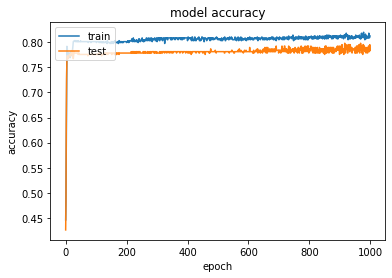

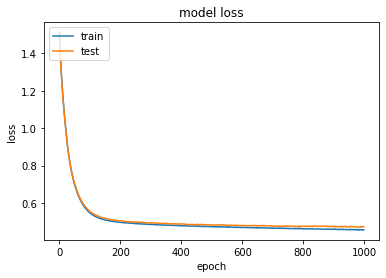

In [236]:
X_train = X
y_train = y

# determine the number of input features
n_features = X_train.shape[1]

# define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_regularizer=l2(0.02), kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(10, activation='relu', kernel_regularizer=l2(0.02), kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

# fit the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=64, verbose=1, validation_split=0.4)

print(history.history.keys())
# summarize history for accuracy
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()
# summarize history for loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

# Next steps
# 1. Regularization
# 2. Add Cabin, Ticket or even Name attributes to the dataset


In [237]:
y_test = model.predict_classes(X_test)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/sequential.py:457: RuntimeWarning: invalid value encountered in greater
  return (proba > 0.5).astype('int32')


In [238]:
idx = 0
result = []
for yvalue in y_test:
    result.append({
        "PassengerId": test["PassengerId"][idx], 
        "Survived": yvalue[0]
    })
    idx = idx + 1

df = pd.DataFrame(result)
df.to_csv('/data/prediction.csv', index=False)